In [1]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
matplotlib.__version__ # should be 2.0.0 or above

'2.0.2'

# Training Dataset

Let's start with the training datasets. Let's load them all into memory with h5py. You can investigate the structure of these HDF5 files using `h5ls` in your terminal window.

The energy collected by each cell in each calorimeter layer is stored in `layer_0`, `layer_1` and `layer_3`. The initial energy of the incident particle is saved in `energy`, while the `overflow` contains the energy that fell outside the calorimeter portion we are considering.

In [3]:
particle = h5py.File('/Users/elenaorlova/data/data_train.h5', 'r')

In [4]:
particle

<HDF5 file "data_train.h5" (mode r)>

In [5]:
particle_0 = particle['layer_0'][:]
particle_1 = particle['layer_1'][:]

In [6]:
real_images_particle = [particle_0, particle_1]

Because of the heterogenous segmentation in eta and phi of each layer of the detector, the images we use to represent the energy deposits in each layer will have different sizes. For convenience later on, we save those sizes in a list.

In [7]:
sizes = [particle_0.shape[1], particle_1.shape[2],
         particle_1.shape[1], particle_1.shape[2]]

In [8]:
print sizes

[5, 5, 5, 5]


Just to give you an idea of what these images look like, let's plot the first photon shower.

In [9]:
matplotlib.rcParams.update({'font.size': 6})

In [10]:
def plot_image(image, layer, vmin=None, vmax=None):
    '''
    Args:
    -----
        image: ndarray with energies collected by each calo cell
        layer: int in {0,1,2}, useful to resize image correctly
        vmin: float, min energy to clip at
        vmax: float, max energy to clip at
    '''
    fig = plt.figure(figsize=(6,6))
    im = plt.imshow(image,
               aspect=float(sizes[layer*2 + 1])/sizes[layer*2],
               interpolation='nearest',
               norm=LogNorm(vmin, vmax)
    )
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params()
   
    xticks = range(sizes[layer*2 + 1])
    yticks = range(sizes[layer*2])
    if layer == 0:
        xticks = xticks[::10]
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel(r'$\eta$ Cell ID')
    plt.ylabel(r'$\phi$ Cell ID')

    plt.tight_layout()
    return im

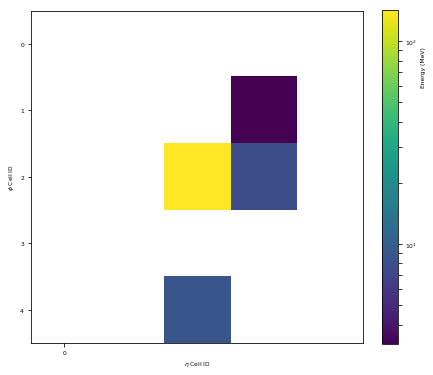

In [11]:
imageix = 0 # let's look at the very first shower
plot_image(particle_0[imageix], layer=0)

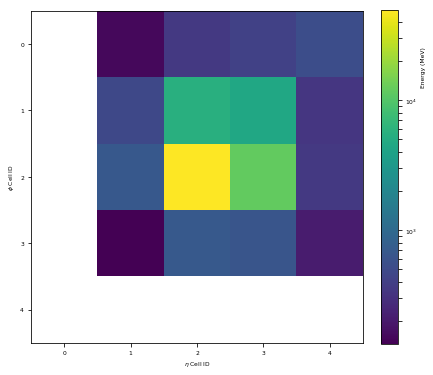

In [12]:
im = plot_image(particle_1[imageix], layer=1)

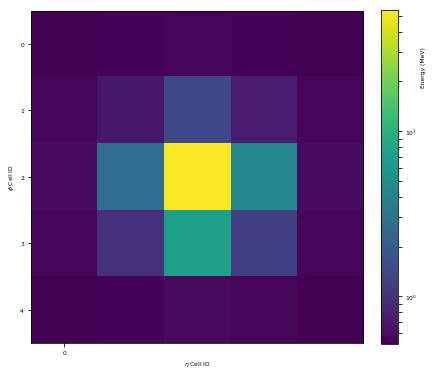

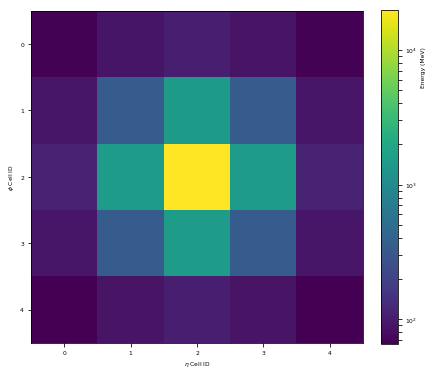

In [13]:
for i in xrange(2):
    plot_image(np.squeeze(real_images_particle[i]).mean(axis=0),
               layer=i,
    )

Just to remind ourselves that this data actually comes from a 3D calorimeter with uneven longitudinal segmentation and heterogeneous granularity in each layer, we can visualize these images in 3D.

In [14]:
import matplotlib
import ndap
reload(ndap)

<module 'ndap' from 'ndap.pyc'>

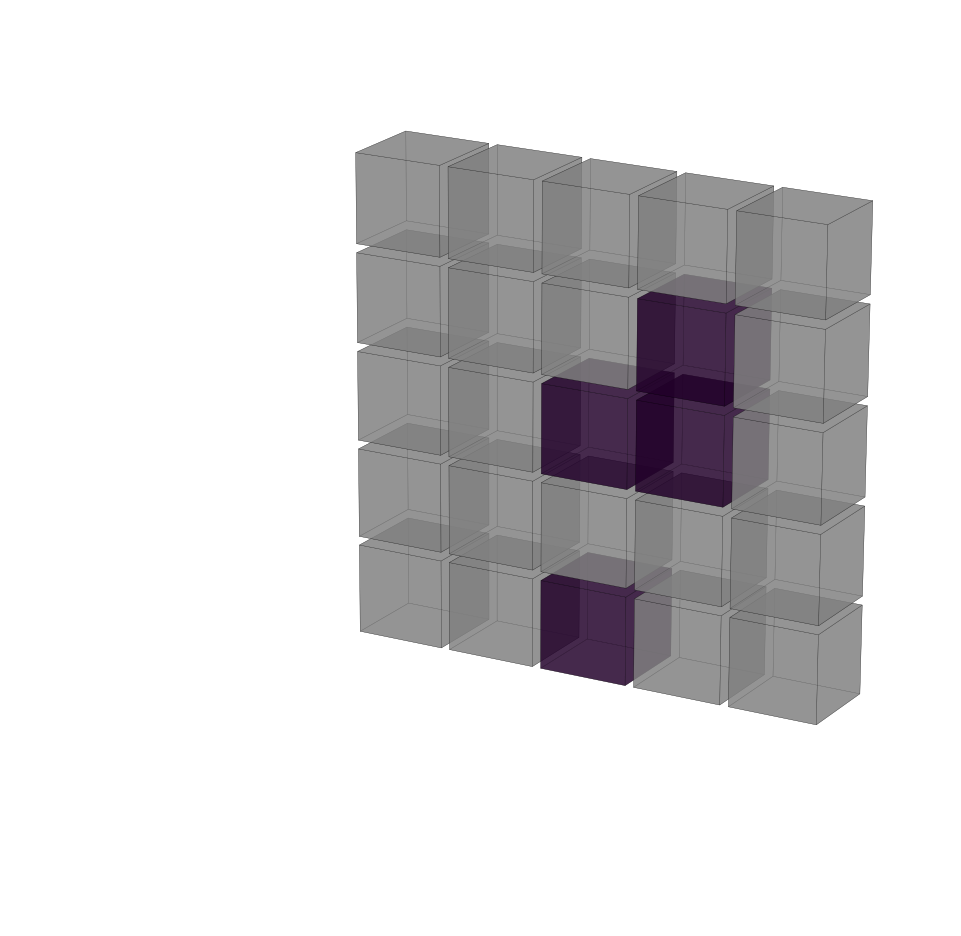

In [15]:
color = im.cmap(im.norm(particle_0[0]))#.mean(axis=0)))
img_size = (5, 5)
depth = 1
subject = np.ones((depth, ) + img_size)

# image settings
plotter = ndap.NDArrayPlotter(subject, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1)) # inter-cube spacing
                              #scale=(40, 39, 1)) # relative lengths
# colors 
colors = np.array(
    [matplotlib.colors.to_hex(c) for c in color.reshape(img_size[0] * img_size[1], 4)]
).reshape((1, ) + img_size)
colors[colors == '#000000'] = '#ffffff'
colors = np.tile(colors, (depth, 1, 1))
plotter.set_color(colors)

(fig, ax) = plotter.render(azim=30, elev=19)
#plt.savefig('0.png', transparent=True)

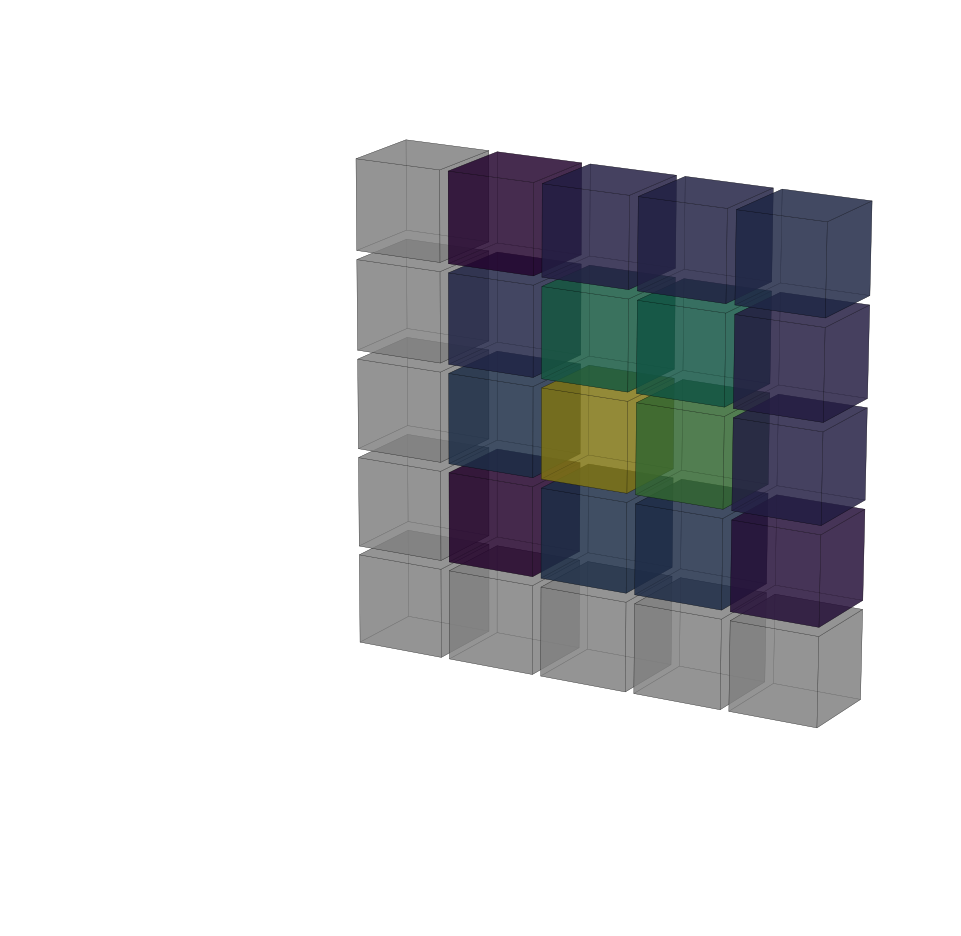

In [16]:
color = im.cmap(im.norm(particle_1[0]))
img_size = (5, 5) # number of cells per side
depth = 1 # number of stacked layers of the same type
subject = np.ones((depth, ) + img_size)

# image settings
plotter = ndap.NDArrayPlotter(subject, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 0.1, 0.1, 0.1)) # inter-cube spacing
                              #scale=(16, 1, 1))
                                                          
# colors 
colors = np.array(
    [matplotlib.colors.to_hex(c) for c in color.reshape(img_size[0] * img_size[1], 4)]
).reshape((1, ) + img_size)
colors[colors == '#000000'] = '#ffffff'
colors = np.tile(colors, (depth, 1, 1))
plotter.set_color(colors)

(fig, ax) = plotter.render(azim=30, elev=17)
#plt.savefig('1.png', transparent=True)

# GAN Sample Generation

Let's build the network architecture we proposed, load its trained weights, and use it to generate synthesized showers. We do all this using `Keras` with the `TensorFlow` backend.

This was our choice for the size of the latent space $z$. If you want to retrain this net, you can try changing this parameter.

In [17]:
latent_size = 1024 

In [18]:
from keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.layers.merge import multiply
import keras.backend as K

Using TensorFlow backend.


In [19]:
%cd ../models/
from architectures import build_generator, build_discriminator, sparse_softmax
from ops import scale, inpainting_attention
%cd ../analysis/

/Users/elenaorlova/gan-model/models
/Users/elenaorlova/gan-model/analysis


In [20]:
# input placeholders
latent = Input(shape=(latent_size, ), name='z') # noise
input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
generator_inputs = [latent, input_energy]

# multiply the (scaled) energy into the latent space
h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

# build three LAGAN-style generators (checkout out `build_generator` in architectures.py)
img_layer0 = build_generator(h, 5, 5)
img_layer1 = build_generator(h, 5, 5)


# outputs
generator_outputs = [
    Activation('relu')(img_layer0),
    Activation('relu')(img_layer1)
]

In [21]:
# build the actual model
generator = Model(generator_inputs, generator_outputs)

In [22]:
# load trained weights
generator.load_weights('/Users/elenaorlova/data/params_generator_epoch_039.hdf5')

Now that the net is instantiated, we can use it to generate images. To do so, we need to provide inputs. In particular, the latent space expects some normally distributed noise, while the requested energy can be an array of your choice. Our net was trained with an uniform spectrum of energies between 1 and 100 GeV, so it should be safe to request any list of energies in that range. You could also try to request an energy outside of that range and see what happens.

In [23]:
latent_size = 1024

In [24]:
# 10,000 is the number of showers we want to generate right now
noise = np.random.normal(0, 1, (10000, latent_size))
sampled_energy = np.random.uniform(1, 200, (10000, 1))

In [25]:
#sampled_energy

In [26]:
images = generator.predict([noise, sampled_energy], verbose=True)

 9984/10000 [============================>.] - ETA: 0s

In [27]:
# we need to multiply images by 1000 to match order of magnitude of generated images to real images
images = map(lambda x: np.squeeze(x * 1000), images)
vmin = [particle_0.mean(axis=0).min(),  particle_1.mean(axis=0).min()]
vmax = [particle_0.mean(axis=0).max(),  particle_1.mean(axis=0).max()]

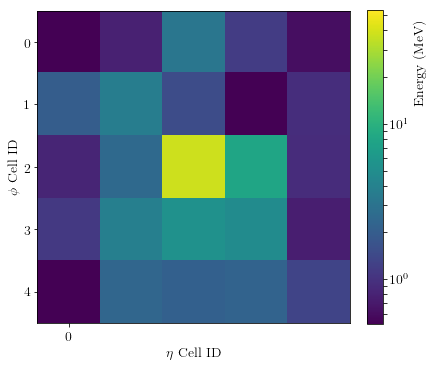

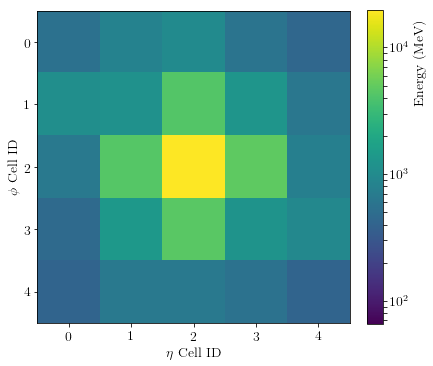

In [28]:
gen_images_particle = [images[0], images[1]]
for i in xrange(2):
    plot_image(np.squeeze(gen_images_particle[i]).mean(axis=0),
               layer=i,
               vmin=vmin[i],
               vmax=vmax[i]
    )
    #plt.savefig('gamma_{}.pdf'.format(i), transparent=True)

Now that we know what the average images look like in each layer, for both GAN and GEANT generated showers, we can do another qualitative test of performance. Specifically, we can pick 5 random images out of the training set and find their nearest neighbor in the synthesized datasets. This can help us visualize whether the generated images display the desired degree of diversity, as well as whether they are simply memorizing the training set or actually learning something interesting.

In [29]:
def plot_nn(layer, gen_images=gen_images_particle, real_images=real_images_particle, vmin=vmin, vmax=vmax, sizes=sizes, nparticles=5):
    '''
    vmin and vmax are the arrays defined above based on GEANT image ranges
    sizes is also defined above
    npartciles: (default=5), number of random showers to plot
    '''
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(1, metric='euclidean')
    nn.fit(gen_images[layer].reshape(gen_images[layer].shape[0], -1))
    f, axarr = plt.subplots(2, nparticles, figsize=(25, 10))
    particles = np.random.randint(low=0, high=real_images[layer].shape[0], size=nparticles)

    for i, sel in enumerate(particles):
        nbr = int(nn.kneighbors(real_images[layer][sel].ravel().reshape(1, -1))[-1])
        def _plot_im(n_row, images):
            im = axarr[n_row, i].imshow(images,
                                        interpolation='nearest',
                                        norm=LogNorm(vmin=vmin[layer], vmax=vmax[layer]),
                                        aspect=sizes[1+(layer*2)] / float(sizes[(0)+(layer*2)]),
                                       )
            axarr[n_row, i].tick_params(axis='both', which='both', bottom='off', top='off',
                                    left='off', right='off', labelbottom='off',
                                    labelleft='off')
            return im

        cnv = [_plot_im(*content) for content in enumerate([real_images[layer][sel], gen_images[layer][nbr]])]
    axarr[0][0].set_ylabel('GEANT')
    axarr[1][0].set_ylabel('GAN')
    cax = f.add_axes([0.93, 0.11, 0.03, 0.8])
    cb = f.colorbar(cnv[0], cax=cax)
    cb.set_label(r'Energy (MeV)', y=0.73)
    #plt.savefig('nn{}.pdf'.format(layer), pad_inches=2, transparent=True, bbox_inches='tight')

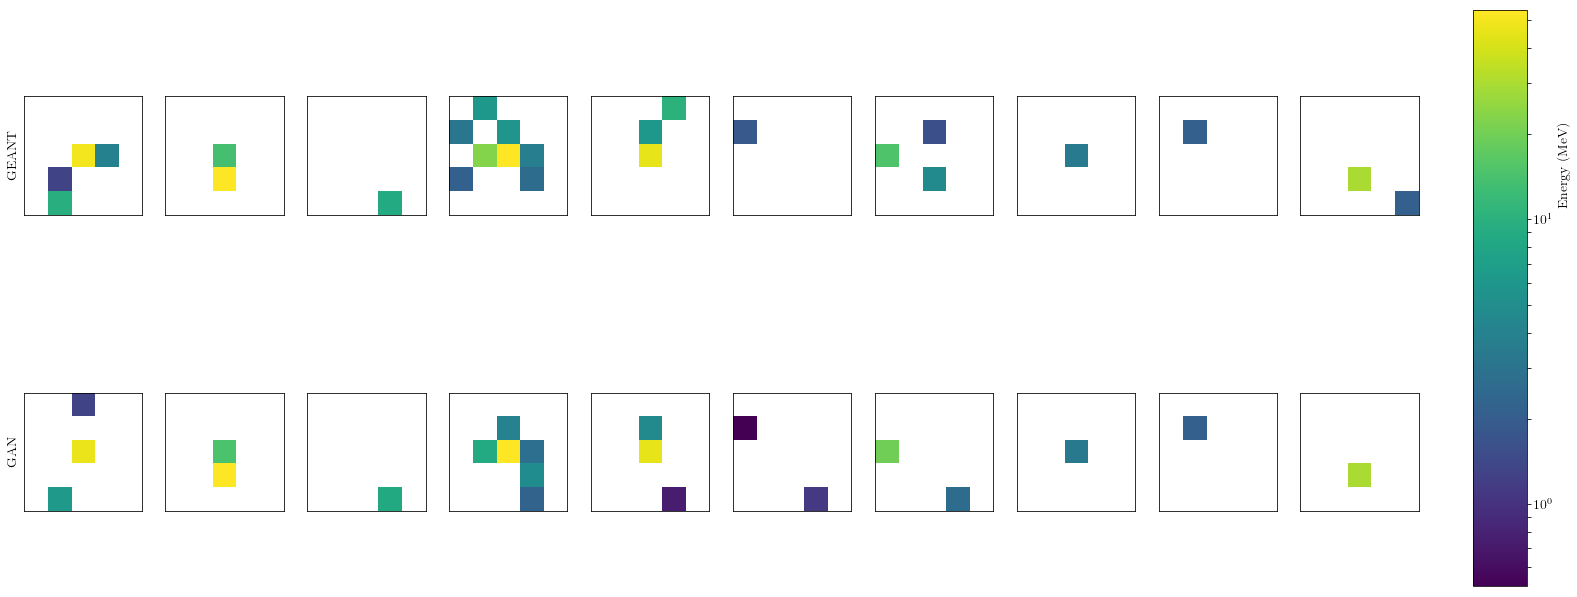

In [30]:
plot_nn(layer=0, nparticles=10)

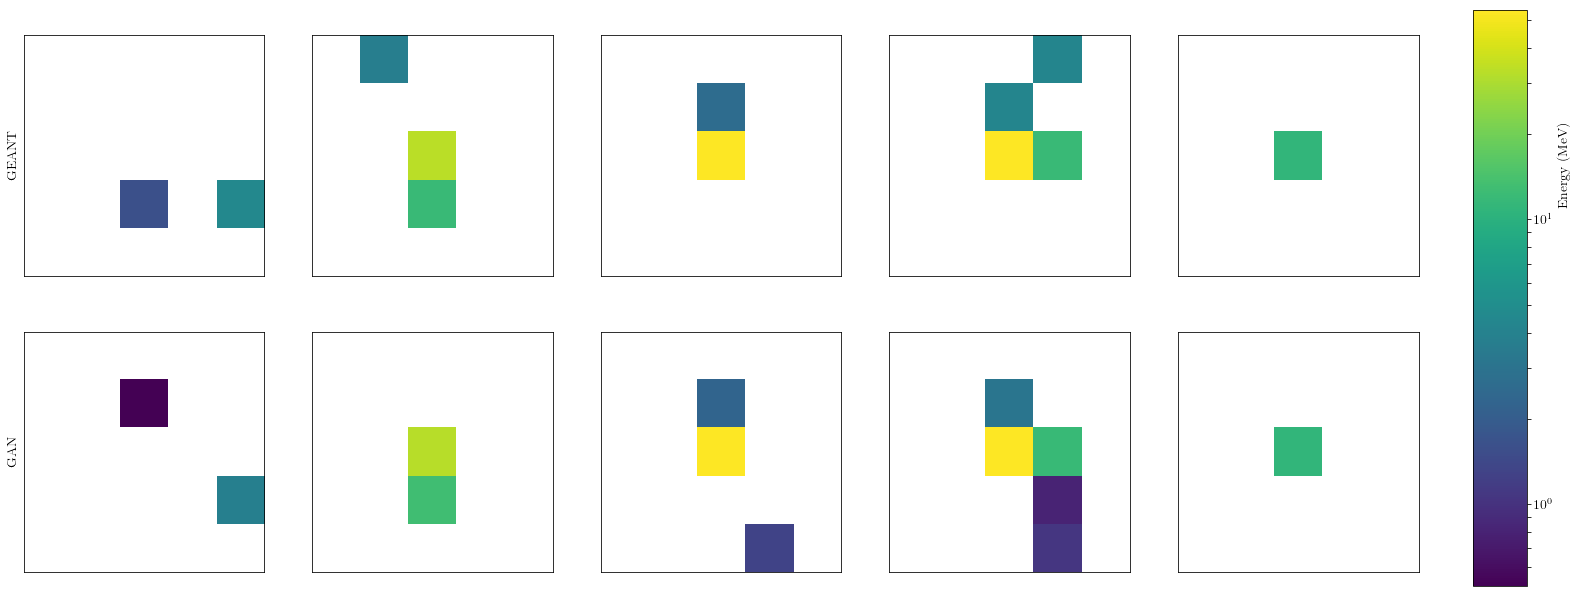

In [31]:
plot_nn(layer=0)

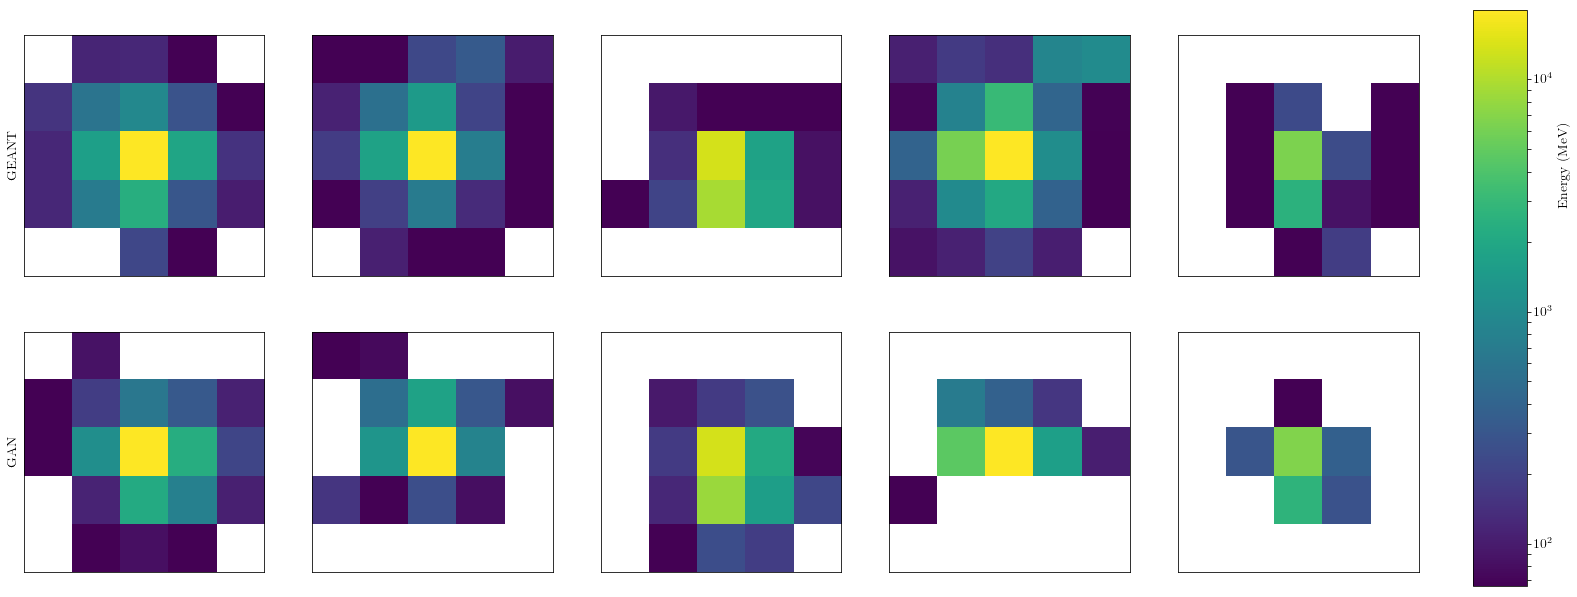

In [32]:
plot_nn(layer=1)

In [33]:
dgen_particle = {
    'layer_0' : np.squeeze(images[0]),
    'layer_1' : np.squeeze(images[1])
}

# Quantitative Performance Evaluation

Showers can be described using useful, engineered 1d variables, some of them known in the field as "shower shape" variables. These not only help distinguish among the different types of particles, but they also allow us to test how well the GAN is able to reproduce the true data distribution it tried to learn. Not that, besides energy and sparsity, none of these variables were directly built into the network, so the network never knew it had to reproduce them with high fidelity.

In [34]:
from feats1d import *
matplotlib.rcParams.update({'font.size': 30})

In [35]:
colors = matplotlib.cm.gnuplot2(np.linspace(0.2, 0.8, 2))

## Sparsity

In [83]:
gen_sparsity_particle = map(lambda x: (x > 1e-10).mean((1, 2)), [v for v in dgen_particle.itervalues()])
real_sparsity_particle = map(lambda x: (x > 1e-10).mean((1, 2)), real_images_particle)

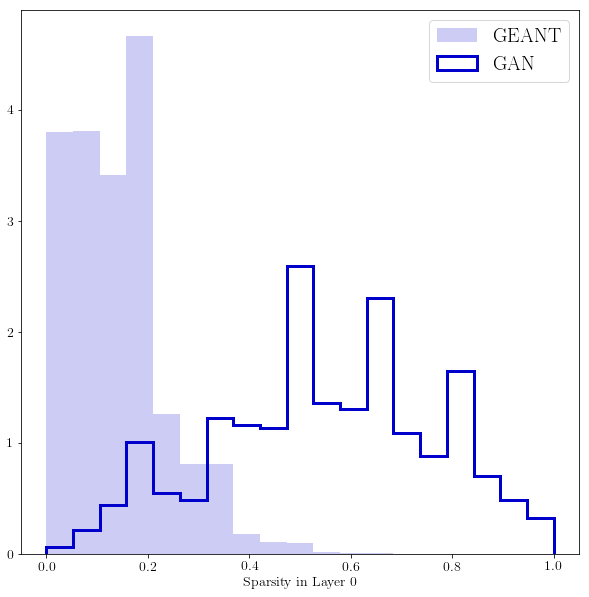

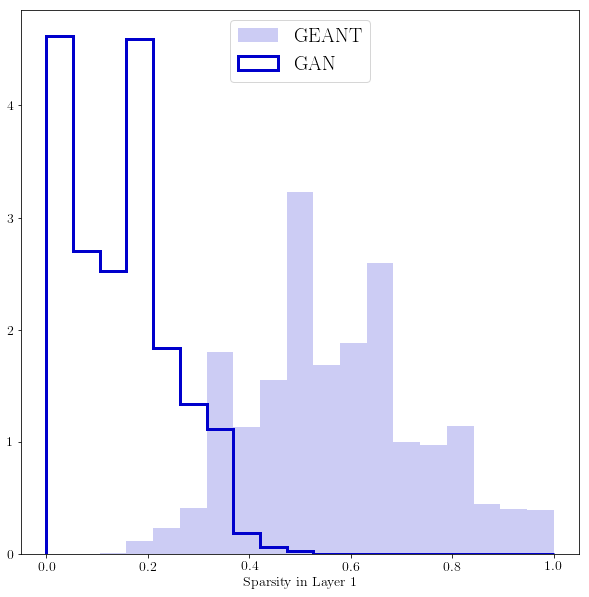

In [84]:
for i in xrange(2):
    bins = np.linspace(0, 1, 20)
    plt.figure(figsize=(10, 10))
    _ = plt.hist(real_sparsity_particle[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True', color=colors[0],
                 label=r' GEANT')
    _ = plt.hist(gen_sparsity_particle[i], bins=bins, histtype='step', linewidth=3,
                 alpha=1, normed='True', color=colors[0],
                 label=r' GAN')
    if i==1:
        loc='upper center'
    else:
        loc = 'upper right'
    plt.legend(loc=loc, ncol=1, fontsize=20)#, mode='expand', fontsize=20)
    plt.xlabel('Sparsity in Layer {}'.format(i))
    #plt.savefig('sparsity_layer{}.pdf'.format(i))

## Depth

In [38]:
def my_depth(d):
    maxdepth = 1 * (d['layer_1'][:].sum(axis=(1, 2)) != 0) 
    maxdepth[maxdepth == 0] = 1 * (d['layer_1'][:][maxdepth == 0].sum(axis=(1, 2)) != 0) 
    return maxdepth

In [39]:
depth_orig_particle = my_depth(particle)
depth_gen_particle = my_depth(dgen_particle)

In [40]:
particle['layer_1']

<HDF5 dataset "layer_1": shape (589618, 5, 5), type "<f4">

In [41]:
print depth_gen_particle

[1 1 1 ..., 1 1 1]


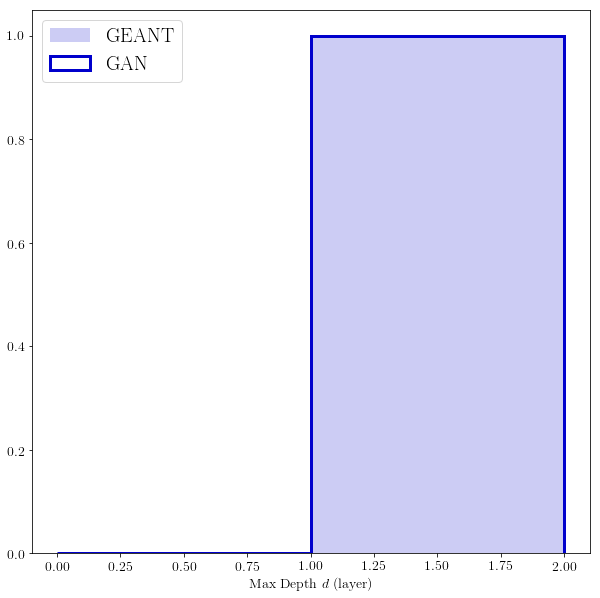

In [45]:
bins = [0, 1, 2]

plt.figure(figsize=(10, 10))
_ = plt.hist(depth_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(depth_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')

# _ = plt.hist(depth_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
# _ = plt.hist(depth_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'Max Depth $d$ (layer)')
#plt.savefig('max_layer_depth.pdf')

## Total Energy

In [47]:
etot_orig_particle = total_energy(particle)
etot_gen_particle = total_energy(dgen_particle)

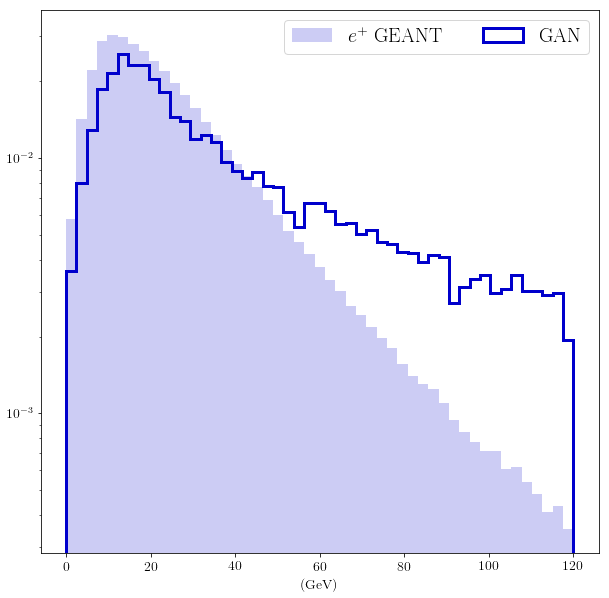

In [48]:
bins = np.linspace(0, 120, 50)
plt.figure(figsize=(10, 10))
_ = plt.hist(etot_orig_particle / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(etot_gen_particle / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper right', fontsize=20, ncol=2)
plt.yscale('log')
plt.xlabel(r' (GeV)')
#plt.savefig('etot.pdf')

## Energy per Layer

In [49]:
e1_orig_particle = energy('1', particle)
e1_gen_particle = energy('1', dgen_particle) 
e0_orig_particle = energy('0', particle)
e0_gen_particle = energy('0', dgen_particle)


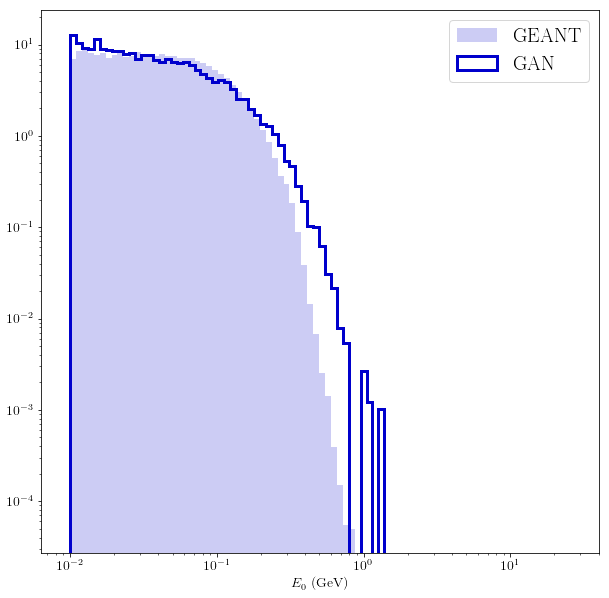

In [50]:
bins=np.logspace(-2, 2, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_particle / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(e0_gen_particle / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=1, fontsize=20)

plt.xlabel(r'$E_0$ (GeV)')
#plt.savefig('e0_loglog.pdf')

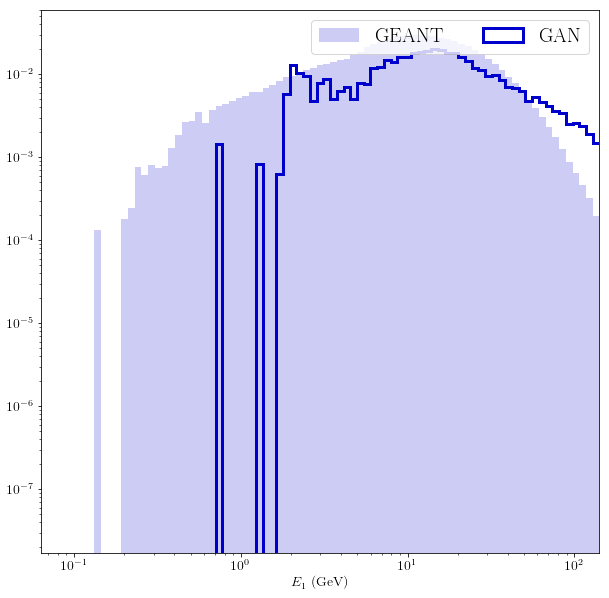

In [51]:
bins=np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig_particle / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(e1_gen_particle / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmax=140)

plt.legend(loc='upper right', ncol=2, fontsize=20)
plt.xlabel(r'$E_1$ (GeV)')
#plt.savefig('e1_loglog.pdf')

## Energy Fractions

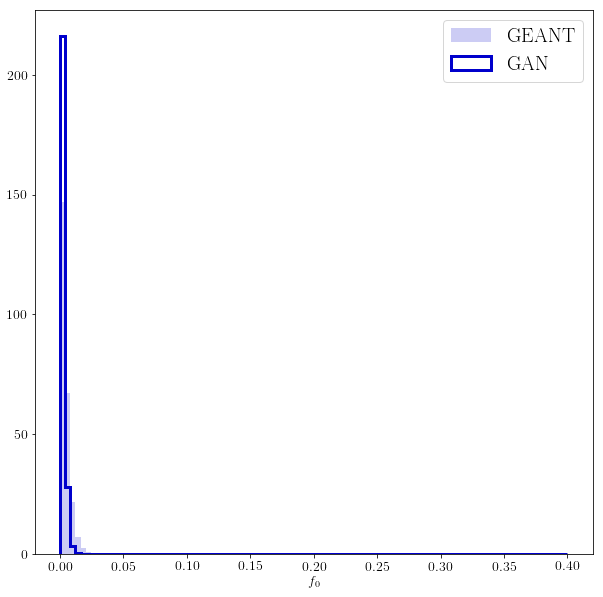

In [52]:
bins = np.linspace(0, 0.4, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_particle / (etot_orig_particle + 1e-6), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(e0_gen_particle / (etot_gen_particle + 1e-6), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)

plt.xlabel(r'$f_0$')#$E_0 / E_\mathrm{tot}$')
#plt.savefig('e0_etot.pdf')

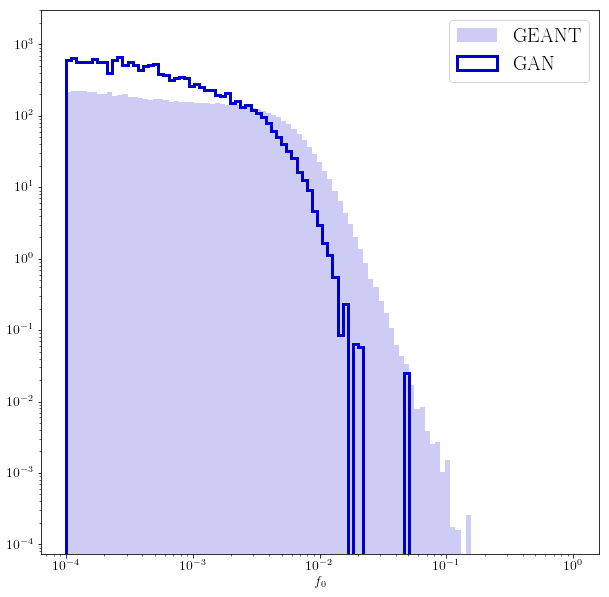

In [53]:
bins = np.logspace(-4, 0, 100) #np.linspace(0, 0.4, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_particle / (etot_orig_particle + 1e-6), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(e0_gen_particle / (etot_gen_particle + 1e-6), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim(ymax=3000)
plt.xlabel(r'$f_0$')#$E_0 / E_\mathrm{tot}$')
#plt.savefig('e0_etot_loglog.pdf')

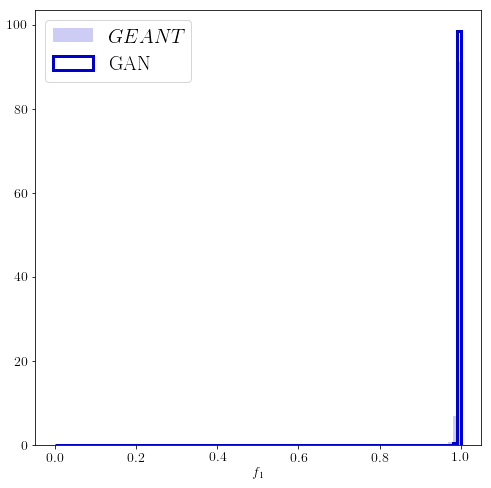

In [54]:
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(e1_orig_particle / (etot_orig_particle + 1e-6), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$ GEANT')
_ = plt.hist(e1_gen_particle / (etot_gen_particle + 1e-6), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)

plt.xlabel(r'$f_1$')#$E_1 / E_\mathrm{tot}$')
#plt.savefig('e1_etot.pdf')

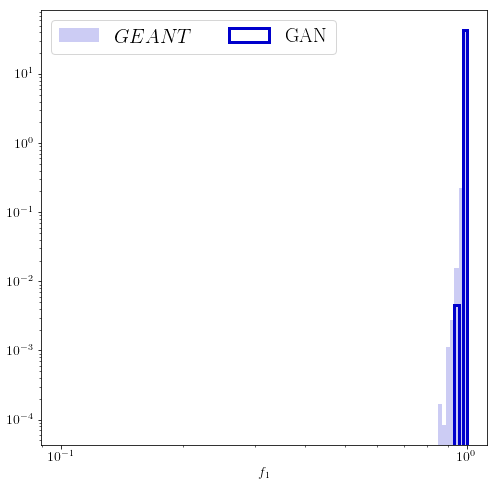

In [55]:
bins=np.logspace(-1, 0, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(e1_orig_particle / (etot_orig_particle + 1e-6), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$ GEANT')
_ = plt.hist(e1_gen_particle / (etot_gen_particle + 1e-6), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper left', ncol=2, fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$f_1$')#$E_1 / E_\mathrm{tot}$')
#plt.savefig('e1_etot_loglog.pdf')

## Shower Depth

In [56]:
lateral_depth_orig_particle = lateral_depth(particle)
lateral_depth_gen_particle = lateral_depth(dgen_particle)

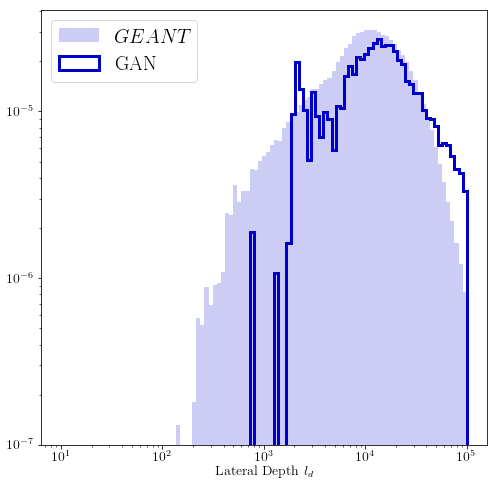

In [57]:
# shower depth
bins = np.logspace(1, 5, 100)#np.linspace(0, 120000, 100)
plt.figure(figsize=(8, 8))

_ = plt.hist(lateral_depth_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$ GEANT')
_ = plt.hist(lateral_depth_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'Lateral Depth $l_d$')
#plt.savefig('lateral_depth.pdf')

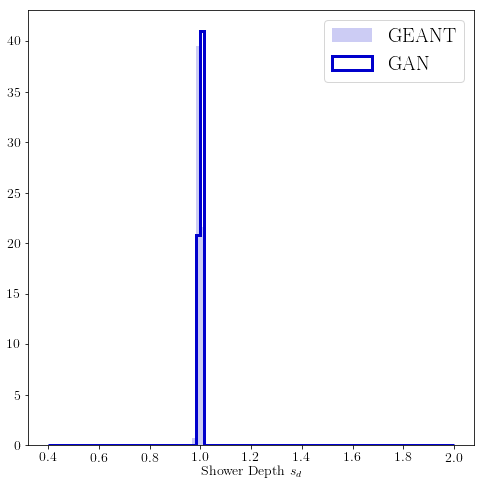

In [58]:
bins = np.linspace(0.4, 2, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(lateral_depth_orig_particle / (etot_orig_particle + 1e-6), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(lateral_depth_gen_particle / (etot_gen_particle + 1e-6), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')

plt.legend(loc='upper right', ncol=1, fontsize=20)

# _ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
# _ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.xlabel(r'Shower Depth $s_d$')
#plt.savefig('shower_depth.pdf')

## Lateral Width per Layer

In [63]:
lateral_width0_orig_particle = layer_lateral_width('0', particle)
lateral_width1_orig_particle = layer_lateral_width('1', particle)
lateral_width0_gen_particle = layer_lateral_width('0', dgen_particle)
lateral_width1_gen_particle = layer_lateral_width('1', dgen_particle)

feats1d.py:119: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((x2 / (e + 1e-7)) - (x / (e + 1e-7)) ** 2)


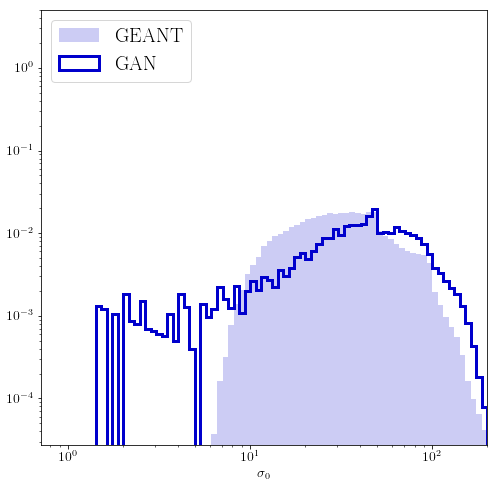

In [64]:
# layer 0 lateral width
bins = np.logspace(0, 3, 100)#np.linspace(0, 100, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(lateral_width0_orig_particle[np.isfinite(lateral_width0_orig_particle)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(lateral_width0_gen_particle[np.isfinite(lateral_width0_gen_particle)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=5)
plt.xlim(xmax=200)
plt.xlabel(r'$\sigma_0$')
#plt.savefig('lateral_width_layer0.pdf')

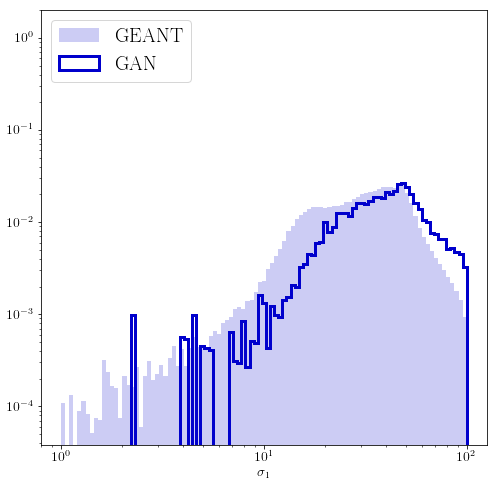

In [65]:
# layer 1 lateral width
bins = np.logspace(0, 2, 100)#np.linspace(0, 70, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(lateral_width1_orig_particle[np.isfinite(lateral_width1_orig_particle)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(lateral_width1_gen_particle[np.isfinite(lateral_width1_gen_particle)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=2)
plt.xlabel(r'$\sigma_1$')
#plt.savefig('lateral_width_layer1.pdf')

## E_ratio

In [66]:
def eratio(images):
    top2 = np.array([np.sort(row.ravel())[::-1][:2] for row in images])
    top2[top2 < 1e-10] = 1e-10
    return (top2[:, 0] - top2[:, 1]) / (top2[:, 0] + top2[:, 1])

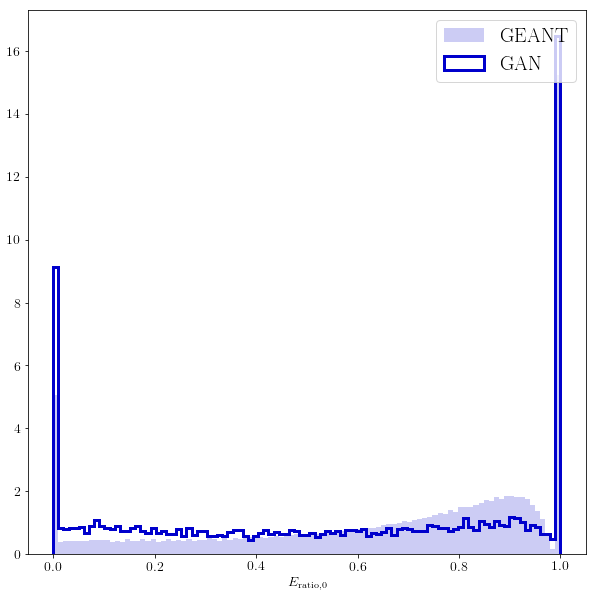

In [67]:
#bins=np.logspace(-2, 2, 100)
bins=np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(eratio(real_images_particle[0]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(eratio(dgen_particle['layer_0']), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)

plt.xlabel(r'$E_{\mathrm{ratio},0}$')
#plt.savefig('eratio.pdf')

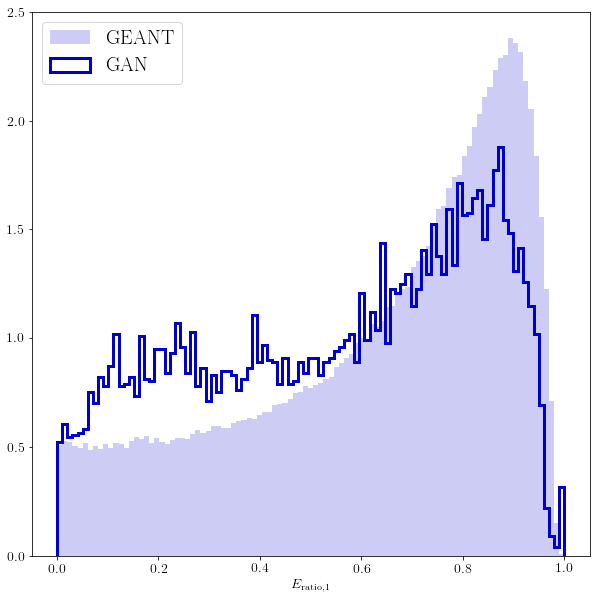

In [68]:
#bins=np.logspace(-2, 2, 100)
bins=np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(eratio(real_images_particle[1]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(eratio(dgen_particle['layer_1']), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)

plt.xlabel(r'$E_{\mathrm{ratio},1}$')
#plt.savefig('eratio1.pdf')